In [23]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')

In [24]:
raw_data = pd.read_csv("Online_Retail.csv")
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


In [25]:
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
print(sales_data.info())
sales_data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB
None


RangeIndex(start=0, stop=541909, step=1)

In [26]:
def extract_product(product_id):
    #pull out all transactions of one product and drop StockCode
    product = sales_data.loc[sales_data['StockCode'] == product_id].drop('StockCode',axis=1)
    product=product.set_index(['InvoiceDate']) #Convert to timeseries 

    #DownSampling to a day
    day_summary = pd.DataFrame()
    day_summary['Quantity'] = product.Quantity.resample('W').sum()
    day_summary = day_summary.fillna(0) #replacing NaN with 0
    day_summary = day_summary.clip(0) #replace -ve values with 0

    day_summary = day_summary['2010-12-12':]#trim as almost no data available before this date
    day_summary['Quantity']+=1#ti avoid -inf while taking log transformation 
    print(day_summary.describe())
    #plot
    fig, ax1 = plt.subplots()
    ax1.plot(day_summary.index, day_summary['Quantity'])
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity')
    # ax1.set_ylim(0,100)
    plt.show()
    return day_summary

         Quantity
count   53.000000
mean   260.396226
std    178.709405
min      6.000000
25%    142.000000
50%    217.000000
75%    345.000000
max    824.000000


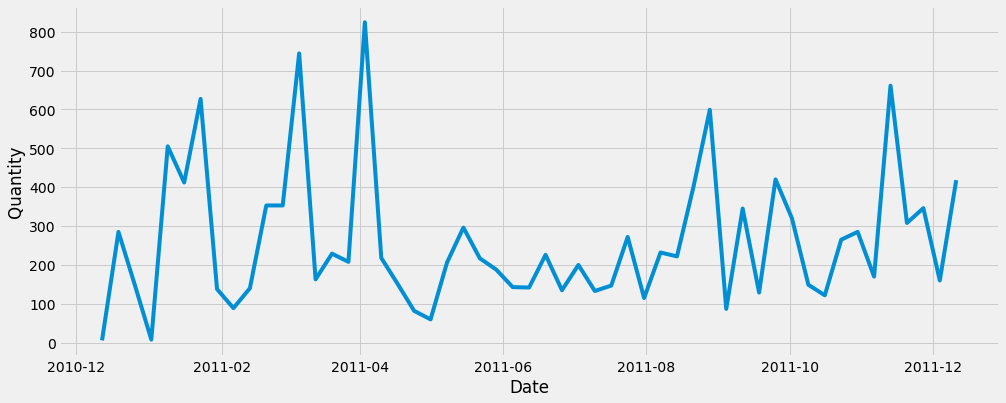

,Quantity
InvoiceDate,
2010-12-12,6.0
2010-12-19,285.0
2010-12-26,148.0
2011-01-02,8.0
2011-01-09,505.0


In [27]:
day_summary = extract_product('22629')
day_summary.head()

In [32]:
#required by prophet
day_summary = day_summary.rename(index = {'InvoiceDate': 'ds'},columns={'Quantity': 'y'})
day_summary.index.rename('ds',inplace=True)
day_summary.head()

,y
ds,
2010-12-12,6.0
2010-12-19,285.0
2010-12-26,148.0
2011-01-02,8.0
2011-01-09,505.0
